## Resources

This notebook is based on book

#### DEEP TIME SERIES FORECASTING With PYTHON: An Intuitive Introduction to Deep Learning for Applied Time Series Modeling




In [1]:
# We need to run the command: pip install xlrd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
excel_file =  pd.ExcelFile("COE.xls")

In [9]:
print(excel_file.sheet_names)

['COE data']


In [38]:
# Load the data into a DataFrame
spreadsheet = excel_file.parse('COE data')

In [11]:
print(spreadsheet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    265 non-null    datetime64[ns]
 1   COE$    265 non-null    float64       
 2   COE$_1  265 non-null    float64       
 3   #Bids   265 non-null    int64         
 4   Quota   265 non-null    int64         
 5   Open?   265 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 12.5 KB
None


We see the spreadsheet contains six columns with 265 rows
(entries). 
- DATE: contains the date of the COE auction, and
the remaining columns the other five variables.
- COE$:  contains the Certificate of Entitlement historical price. We will use it as our target variable and store
it in an object called data:

It appears that the first COE price (back in August 1990) was
 7,400 (row 0), and the second price considerably higher at
11,100. The individuals who brought at this price got a rough
deal, because the price dropped to around 5,000 and then less
than 3,200 over the next few months. I’d be “kicking myself”
if I’d paid 11,000 for something that trades at more than a
50% discount a month later. My guess is those who brought at
11,000 were probably too rich to care!

In [39]:
spreadsheet[['DATE','COE$']].head()

,DATE,COE$
0,1990-08-01,7400.0
1,1990-09-01,11100.0
2,1990-10-01,5002.0
3,1990-11-01,3170.0
4,1990-12-01,3410.0


Did you notice the error for 15th February, 15th April and 15th
June? All are reported as the year 2002; they should say 2004.
This quite is a common type of coding error.

In [40]:
spreadsheet['DATE'][193:204]

193   2004-02-01
194   2002-02-15
195   2004-03-01
196   2004-03-15
197   2004-04-01
198   2002-04-15
199   2004-05-01
200   2004-05-15
201   2004-06-01
202   2002-06-15
203   2004-07-01
Name: DATE, dtype: datetime64[ns]

Let’s correct it

In [41]:
spreadsheet.iloc[194,0] = '2004-02-15 00:00:00'
spreadsheet.iloc[198,0] = '2004-04-15 00:00:00'
spreadsheet.iloc[202,0] = '2004-06-15 00:00:00'

In [42]:
spreadsheet['DATE'][193:204]

193    2004-02-01 00:00:00
194    2004-02-15 00:00:00
195    2004-03-01 00:00:00
196    2004-03-15 00:00:00
197    2004-04-01 00:00:00
198    2004-04-15 00:00:00
199    2004-05-01 00:00:00
200    2004-05-15 00:00:00
201    2004-06-01 00:00:00
202    2004-06-15 00:00:00
203    2004-07-01 00:00:00
Name: DATE, dtype: object

- Saving data

In [46]:
loc = "COE.csv"
spreadsheet.to_csv(loc)

The task of the neuron is to perform a weighted sum of input
signals and apply an activation function before passing the output
to the next layer. 

The hidden layer neurons perform
the summation on the information passed to them from the input layer neurons; and the output layer neurons perform
the summation on the weighted information passed to them
from the hidden layer neurons.


The **sigmoid function** takes a real-valued number and
“squashes” it into a range between 0 and 1.

\begin{equation*}
f(u) \frac{1}{1+e^{-c u }}
\end{equation*}

It gained popularity partly because the output of the function
can be interpreted as the probability of the artificial neuron
“firing”.

The derivative is used to
learn the weight vectors via an algorithm known as **stochastic gradient descent**.

- Rescale the Input Data

Deep neural networks are sensitive to the scale of the input
data. It is good practice to
re-scale the data to the range -1 to +1 or 0 to 1. This can be
achieved via the MinMaxScaler method in the sklearn module:

In [60]:
data = spreadsheet['COE$']
x = data

In [63]:
x.head()

0     7400.0
1    11100.0
2     5002.0
3     3170.0
4     3410.0
Name: COE$, dtype: float64

In [64]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
print(scaler)

MinMaxScaler(copy=True, feature_range=(0, 1))


This informs us that scaler will scale the data into the 0,1
range. 

Note that copy=True is the default setting. 

If the input is already a numpy array you can set it to False to perform in
place row normalization and avoid a copy. However, we set it
to True because x (and data) are Pandas Series:

In [55]:
type(x)

pandas.core.series.Series

- Transform *x* to a numpy array (format accepted by the deep NN model)

In [65]:
x  = np.array(x).reshape((len(x),))

In [70]:
x.shape

(265,)

- Normalize data applying Log Transformation

In [68]:
x = np.log(x)

- Rescale using *fit_transform*: It requires a 2D array. But our *x* array is 1D array.  We need to reshape again

In [72]:
x = x.reshape(-1,1)
x.shape

(265, 1)

In [74]:
x = scaler.fit_transform(x)

- After reshape we need to transform our 2D arrya to back 1D array for incorporate it in our NN model

In [75]:
x = x.reshape(-1)
x.shape

In [76]:
# Check the data are sclaed appropriately
print(round(x.min(),2))
print(round(x.max(),2))

0.0
1.0


## Stats Models: Partial Autocorrelation Function

#### We need to determine how many past observations to include in our model. 

A simple way to do this is to use partial autocorrelations. The
partial autocorrelation function (PACF) measures directly how
an observation is correlated with an observation n time steps
apart.

For
example, if $x_t$ is a time-series observation measured at time t,
then the partial correlation between $x_t$ and $x_{t−3}$ is the amount
of correlation between $x_t$ and $x_{t−3}$ that is not explained by their
common correlations with $x_{t−1}$ and $x_{t−2}$.

In [81]:
from statsmodels.tsa.stattools import pacf
x_pacf = pacf(x, nlags = 5, method = 'ols')

The object x_pacf contains the actual partial autocorrelations.

Just like regular correlations they range between -1
to +1.

Where +1 indicates a strong positive association, -1 indicates a strong negative association, and 0 signifies no association.

The first value is 1 because it represents the correlation of x_t
with itself. The second partial correlation takes the value of
approximately 0.96, and indicates that xt and xt−1 are highly
correlated. This might be expected, as it is reasonable to assume
there is some relationship between today’s COE price and
the price yesterday. However, the third partial autocorrelation
is moderately negative, and the remaining values are rather
small.

In [83]:
x_pacf

array([ 1.        ,  0.95969034, -0.27093837,  0.22144024, -0.04729577,
        0.07360662])

In [85]:
x_pacf = pacf(x, nlags = 40, method = 'ols')
x_values = np.arange(len(x_pacf))

Figure 3.4 plots the partial autocorrelations for 40 lags
alongside an approximate 95% statistical confidence interval
(dotted gray line). It appears observations past one time lag
have little association with the current COE price.

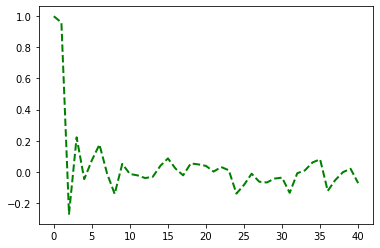

In [99]:
plt.plot(x_values, x_pacf, 'g--', linewidth=2, markersize=12)

The **Tanh activation function** $f(u) = tanh(u)$is a popular alternative to the
sigmoid function and produces output in the range −1 to +1. It is sometimes more effective for **modeling
complex nonlinear relations.**

The Tanh is symmetric around zero - only zero-valued inputs are
mapped to near-zero outputs. In addition, strongly negative
inputs will map to negative outputs. These properties make
the network less likely to get “stuck” during training.

## Neural network Architecture for Time Series Forecasting (nnet-ts)

The model predicts next months COE price given this months COE price. This is called a **one step ahead** forecast.

In [108]:
# if you have any probelms with this package go to the folder where the package is installed and open the file
# __init__.py and modify the line 
# and modify the similiar line to from .TimeSeriesNnet import TimeSeriesNnet
from nnet_ts import *

In [ ]:
count = 0 
ahead =12 # Since 12 one step ahead forecasts are to be calculated,
pred = [] # will store each of the 12 one step ahead predictions.

In [120]:
count = 0 
ahead =12 # Since 12 one step ahead forecasts are to be calculated,
pred = [] # will store each of the 12 one step ahead predictions.

while (count < ahead):
    end = len(x) - ahead + count
    print(end)
    np.random.seed(2016)
    
    # Model with two hidden layers. The first hidden layer contains 7 nodes, and the second
    # hidden layer contains 3 nodes. Both layers use the tanh activation function.
    fit1 =  TimeSeriesNnet(hidden_layers = [7,3], activation_functions = ['tanh', 'tanh'])
    # On each iteration the model is fit to the data with a one time step lag via the fit function.
    fit1.fit(x[0:end], lag=1,epochs=100)
    
    # This is followed by the predict method used to calculate the forecast. The parameter n_ahead is set to 1 to
    # generate a 1 time step ahead forecast.
    out = fit1.predict_ahead(n_ahead = 1)
    
    print('Obs: ', count +1, ' x= ', round(x[count],4), ' prediction = ', round(pd.Series(out),4) )
    
    # The forecast at each iteration, stored in the object out, is appended to pred.
    pred.append(out)
    
    count = count + 1

253


c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\nnet_ts\TimeSeriesNnet.py:29: RuntimeWarning: divide by zero encountered in log
  self.y = np.log(self.timeseries[self.lag:])
c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\nnet_ts\TimeSeriesNnet.py:60: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.nn.fit(self.X, self.y, nb_epoch = self.epochs, verbose = self.verbose)


Obs:  1  x=  0.4303  prediction =  0    0.5177
dtype: float64
254


c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\nnet_ts\TimeSeriesNnet.py:29: RuntimeWarning: divide by zero encountered in log
  self.y = np.log(self.timeseries[self.lag:])
c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\nnet_ts\TimeSeriesNnet.py:60: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.nn.fit(self.X, self.y, nb_epoch = self.epochs, verbose = self.verbose)


Obs:  2  x=  0.5174  prediction =  0    0.524
dtype: float64
255


c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\nnet_ts\TimeSeriesNnet.py:29: RuntimeWarning: divide by zero encountered in log
  self.y = np.log(self.timeseries[self.lag:])
c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\nnet_ts\TimeSeriesNnet.py:60: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.nn.fit(self.X, self.y, nb_epoch = self.epochs, verbose = self.verbose)


Obs:  3  x=  0.3462  prediction =  0    0.5391
dtype: float64
256


c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\nnet_ts\TimeSeriesNnet.py:29: RuntimeWarning: divide by zero encountered in log
  self.y = np.log(self.timeseries[self.lag:])
c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\nnet_ts\TimeSeriesNnet.py:60: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.nn.fit(self.X, self.y, nb_epoch = self.epochs, verbose = self.verbose)


Obs:  4  x=  0.2482  prediction =  0    0.5604
dtype: float64
257


c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\nnet_ts\TimeSeriesNnet.py:29: RuntimeWarning: divide by zero encountered in log
  self.y = np.log(self.timeseries[self.lag:])
c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\nnet_ts\TimeSeriesNnet.py:60: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.nn.fit(self.X, self.y, nb_epoch = self.epochs, verbose = self.verbose)


Obs:  5  x=  0.2639  prediction =  0    0.5803
dtype: float64
258


c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\nnet_ts\TimeSeriesNnet.py:29: RuntimeWarning: divide by zero encountered in log
  self.y = np.log(self.timeseries[self.lag:])
c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\nnet_ts\TimeSeriesNnet.py:60: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.nn.fit(self.X, self.y, nb_epoch = self.epochs, verbose = self.verbose)


Obs:  6  x=  0.1979  prediction =  0    0.5626
dtype: float64
259


c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\nnet_ts\TimeSeriesNnet.py:29: RuntimeWarning: divide by zero encountered in log
  self.y = np.log(self.timeseries[self.lag:])
c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\nnet_ts\TimeSeriesNnet.py:60: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.nn.fit(self.X, self.y, nb_epoch = self.epochs, verbose = self.verbose)


Obs:  7  x=  0.0  prediction =  0    0.5438
dtype: float64
260


c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\nnet_ts\TimeSeriesNnet.py:29: RuntimeWarning: divide by zero encountered in log
  self.y = np.log(self.timeseries[self.lag:])
c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\nnet_ts\TimeSeriesNnet.py:60: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.nn.fit(self.X, self.y, nb_epoch = self.epochs, verbose = self.verbose)


Obs:  8  x=  0.1064  prediction =  0    0.5458
dtype: float64
261


c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\nnet_ts\TimeSeriesNnet.py:29: RuntimeWarning: divide by zero encountered in log
  self.y = np.log(self.timeseries[self.lag:])
c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\nnet_ts\TimeSeriesNnet.py:60: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.nn.fit(self.X, self.y, nb_epoch = self.epochs, verbose = self.verbose)


Obs:  9  x=  0.3875  prediction =  0    0.5519
dtype: float64
262


c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\nnet_ts\TimeSeriesNnet.py:29: RuntimeWarning: divide by zero encountered in log
  self.y = np.log(self.timeseries[self.lag:])
c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\nnet_ts\TimeSeriesNnet.py:60: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.nn.fit(self.X, self.y, nb_epoch = self.epochs, verbose = self.verbose)


Obs:  10  x=  0.4726  prediction =  0    0.5734
dtype: float64
263


c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\nnet_ts\TimeSeriesNnet.py:29: RuntimeWarning: divide by zero encountered in log
  self.y = np.log(self.timeseries[self.lag:])
c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\nnet_ts\TimeSeriesNnet.py:60: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.nn.fit(self.X, self.y, nb_epoch = self.epochs, verbose = self.verbose)


Obs:  11  x=  0.5188  prediction =  0    0.5812
dtype: float64
264


c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\nnet_ts\TimeSeriesNnet.py:29: RuntimeWarning: divide by zero encountered in log
  self.y = np.log(self.timeseries[self.lag:])
c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\nnet_ts\TimeSeriesNnet.py:60: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.nn.fit(self.X, self.y, nb_epoch = self.epochs, verbose = self.verbose)


Obs:  12  x=  0.5406  prediction =  0    0.5508
dtype: float64


- **Note:** The data is normalized and nw we need inverse it to obtain the real values. For this we use **inverse_transform** function

In [122]:
pred1 = scaler.inverse_transform(pred)
pred1 = np.exp(pred1)
print(np.round(pred1,1))

[[11117.2]
 [11446. ]
 [12279.8]
 [13562.4]
 [14880.4]
 [13699.3]
 [12551.4]
 [12671.3]
 [13035.4]
 [14407.1]
 [14942.2]
 [12969.3]]


In [129]:
x_values = np.arange(12)

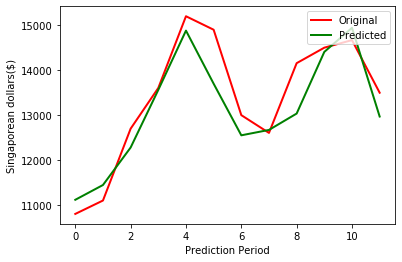

In [152]:
plt.plot(x_values,data[(264-12):264], 'r-', linewidth=2, markersize=12)
plt.plot(x_values, pred1, 'g-', linewidth=2, markersize=12)
plt.xlabel('Prediction Period')
plt.ylabel('Singaporean dollars($)')
plt.legend(('Original', 'Predicted'),loc='upper right')